#### Imports:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from datetime import datetime as dt
import seaborn as sns
import time
import scipy as sc

#### Load Dataset:

In [2]:
df = pd.read_csv('spoke_snoozes.csv')
df.head(3)

,id,option,user_id,channel_id,report_id,created_at,updated_at,prompt_time,report_time,reason
0,7f3ba50e-dd85-4d7f-9f53-170356e92575,15 minutes,7d27b303-3c52-4667-98c3-2ea88abbe54a,d7321b41-7815-47e1-936a-ad45b295d8b2,281da364-10c6-4a4a-b39e-39e7d69613a9,2021-10-14 16:40:56.597000+00:00,2021-10-14 17:49:20.552893+00:00,17:00:00,09:45:00,Too busy!
1,2f64f8f5-a6f4-4678-a904-11381ebf12bc,15 minutes,7d27b303-3c52-4667-98c3-2ea88abbe54a,d7321b41-7815-47e1-936a-ad45b295d8b2,281da364-10c6-4a4a-b39e-39e7d69613a9,2021-10-14 17:27:56.752000+00:00,2021-10-14 17:49:20.552893+00:00,17:00:00,09:45:00,NaN
2,3c62bffe-b47e-48b6-a69a-98c7b402ff42,1 hour,7e29b25f-4006-4108-b08e-0b3ab1b6307e,d7321b41-7815-47e1-936a-ad45b295d8b2,281da364-10c6-4a4a-b39e-39e7d69613a9,2021-10-14 16:41:52.760000+00:00,2021-10-15 12:05:26.585350+00:00,17:00:00,09:45:00,NaN


Let's look at the overview of the dataset:

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97 entries, 0 to 96
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           97 non-null     object
 1   option       97 non-null     object
 2   user_id      97 non-null     object
 3   channel_id   97 non-null     object
 4   report_id    97 non-null     object
 5   created_at   97 non-null     object
 6   updated_at   97 non-null     object
 7   prompt_time  97 non-null     object
 8   report_time  97 non-null     object
 9   reason       13 non-null     object
dtypes: object(10)
memory usage: 7.7+ KB


Helper function:

In [4]:
def column_view(col):
  items = list(set(df[col]))
  print("Total items in", col, ":", len(items))
  print("Snoozes per", col, ":")
  print(df[col].value_counts())
  df[col].hist()

#### Users:

In [5]:
le = LabelEncoder()
df['user_idx'] = le.fit_transform(df['user_id'])

Total items in user_idx : 9
Snoozes per user_idx :
4    24
1    23
2    21
3    11
5     8
8     4
6     3
7     2
0     1
Name: user_idx, dtype: int64


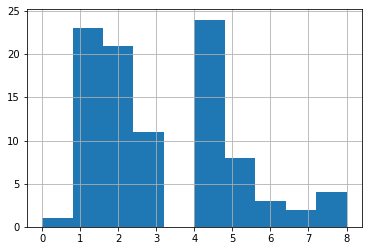

In [6]:
column_view('user_idx')

#### Reports

In [7]:
df.groupby(['user_idx'])['report_id'].count()

user_idx
0     1
1    23
2    21
3    11
4    24
5     8
6     3
7     2
8     4
Name: report_id, dtype: int64

We can observe, users with alias: **1,2,4 are using snooze feature more**.

*This can create a bias towards our assumptions.*

### 1. i. Should the options available for snoozing change and if so to what and why?

Total items in option : 4
Snoozes per option :
1 hour        53
15 minutes    22
30 minutes    13
3 hours        9
Name: option, dtype: int64


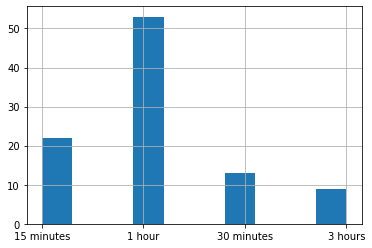

In [8]:
column_view('option')

In [9]:
prefix_dict = {
    '1 hour':     60,
    '15 minutes': 15,
    '30 minutes': 30,
    '3 hours':    180
}

# replace data
df['option_time'] = df['option'].map(prefix_dict)

Let's take a look at each user's option:

In [10]:
df.groupby(['user_idx'])['option_time'].describe()

,count,mean,std,min,25%,50%,75%,max
user_idx,,,,,,,,
0,1.0,60.000000,NaN,60.0,60.00,60.0,60.00,60.0
1,23.0,61.304348,50.950453,15.0,22.50,60.0,60.00,180.0
2,21.0,50.000000,16.658331,15.0,30.00,60.0,60.00,60.0
3,11.0,65.454545,39.840591,30.0,60.00,60.0,60.00,180.0
4,24.0,70.000000,53.201831,15.0,52.50,60.0,60.00,180.0
5,8.0,54.375000,54.930963,15.0,15.00,45.0,60.00,180.0
6,3.0,20.000000,8.660254,15.0,15.00,15.0,22.50,30.0
7,2.0,22.500000,10.606602,15.0,18.75,22.5,26.25,30.0
8,4.0,15.000000,0.000000,15.0,15.00,15.0,15.00,15.0


- We can see from the **mean** values that most users prefer option time which are *more than 15 minutes*. So, my hypothesis is, option **15 minutes** might be an unpopular choice.

- We can also see, most users has mean close to 1 hour (60 minutes). 

- We can assume that, users do not like a snooze after every 15 minutes and that is the reason people are using longer snooze options like: 1 hour and 3 hours.

In [11]:
# usage of 3 hours per user
df[df['option_time'] == 180].groupby(['user_idx'])['option_time'].count()

user_idx
1    3
3    1
4    4
5    1
Name: option_time, dtype: int64

In [12]:
# ratio of using 3 hours
len(df[df['option_time'] == 180]) / len(df)

0.09278350515463918

- We can see option **3 hours** has been used only few times (**9%**). We can hypothesize that people used this option when they were very busy and got annoyed by the snooze every **15 minutes**.

Let's look at the probability distribution of the option times:

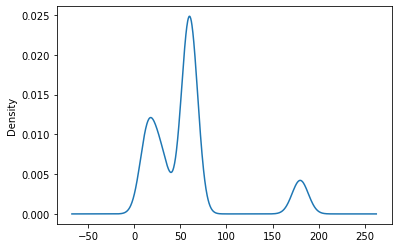

In [13]:
# estimate the probability density function (PDF)
df['option_time'].plot.kde(bw_method=0.2)

We can smoothen the curve to get a bell shape (Gaussian distribution):

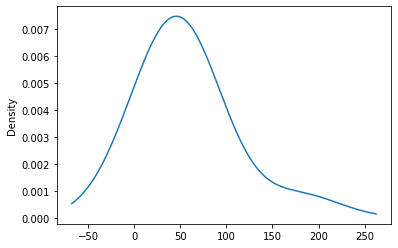

In [14]:
df['option_time'].plot.kde(bw_method=1)

In [15]:
df['option_time'].describe()

count     97.000000
mean      56.907216
std       43.889322
min       15.000000
25%       30.000000
50%       60.000000
75%       60.000000
max      180.000000
Name: option_time, dtype: float64

- We can see that the mean is around 56.9 minutes (close to 1 hour).

- Considering previous assumptions and 1 hour to be mean value for *option*, my suggestion is to remove the option: 3 hours

- Instead have the following options: ($\sigma = 45, \mu = 60$)
  * 15 minutes ($\sigma - \mu$)
  * 30 minutes ($\mu/2$)
  * 1 hour ($\mu$)
  * 2 hour (almost $\sigma + \mu$)

- Set **1 hour** as default option.

### 1. ii. Are there patterns in usage associated with the day of the week?

In [16]:
# snooze updated on day of the week (Monday=0, Sunday=6)
df['dow'] = df['updated_at'].apply(lambda x: pd.Timestamp(x).dayofweek)

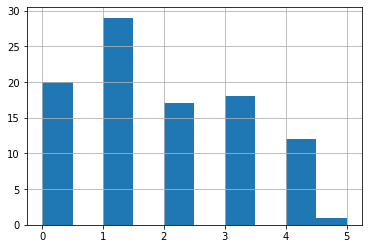

In [17]:
# snooze per day
df['dow'].hist()

- **Tuesday** seems to be the day when users had highest snoozes.
- We see more snoozes on **Monday** and **Tuesday** than the other weekdays. It is plausible that these days of the week have `prompt_time` at a later time.
- On **Friday**, people used lowest snoozes. It can be helpful setting `prompt_time` at a earlier time.

Let's look at different snooze options used for each day:

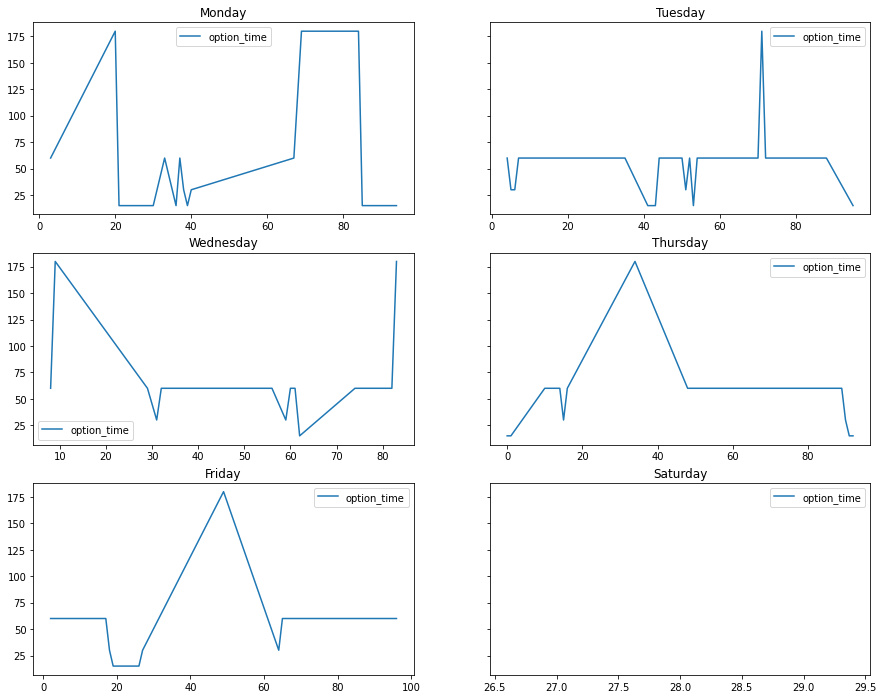

In [18]:
# group options by day of the week
grouped = df.groupby(['dow'])['option_time']

dayOfWeek={0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}
ncols,loop = 2, 0
nrows = int(np.ceil(grouped.ngroups/ncols))
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15,12), sharey=True)
for (key, ax) in zip(grouped.groups.keys(), axes.flatten()):
    grouped.get_group(key).plot(ax=ax)
    ax.set_title(dayOfWeek[loop])
    ax.legend()
    loop += 1
plt.show()

In [19]:
df.groupby(['dow'])['option_time'].describe()

,count,mean,std,min,25%,50%,75%,max
dow,,,,,,,,
0,20.0,58.500000,64.728177,15.0,15.0,22.5,60.0,180.0
1,29.0,53.275862,30.421910,15.0,30.0,60.0,60.0,180.0
2,17.0,67.941176,44.407869,15.0,60.0,60.0,60.0,180.0
3,18.0,53.333333,37.180007,15.0,30.0,60.0,60.0,180.0
4,12.0,55.000000,43.536818,15.0,30.0,60.0,60.0,180.0
5,1.0,30.000000,NaN,30.0,30.0,30.0,30.0,30.0


- All weekdays have mean close to 1 hour.
- From the figures above, we can also see most usage of option `1 hour` with sudden peaks at `3 hour` and sudden falls at `15 minute`.

### 2. The suggested new `prompt_time` for `channel_id = d7321b41-7815-47e1-936a-ad45b295d8b2`

We will look at the `updated_at` and `created_at` timestamps to predict a new `prompt_time`.

#### updated_at:

In [20]:
# use only hour and minutes from the updated time
def hour_miuntes(val):
  t = pd.Timestamp(val).tz_convert("Europe/Berlin").time()
  return t.hour * 100 + t.minute

In [21]:
df['update_time'] = df['updated_at'].apply(lambda x: hour_miuntes(x))

Let's have a closer look when snoozes were updated:

Total items in update_time : 64
Snoozes per update_time :
1025    3
1908    3
251     3
1948    3
1727    2
       ..
949     1
946     1
1840    1
1838    1
1406    1
Name: update_time, Length: 64, dtype: int64


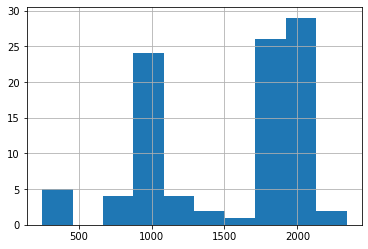

In [22]:
column_view('update_time')

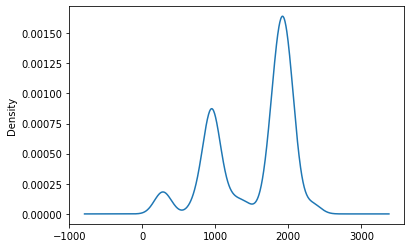

In [23]:
# snooze updates for the channel d7321b41-7815-47e1-936a-ad45b295d8b2
chdf = df[df['channel_id'] == "d7321b41-7815-47e1-936a-ad45b295d8b2"]
chdf['update_time'].plot.kde(bw_method=0.2)

Consider time 3pm - 6pm:

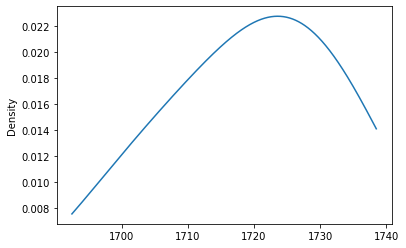

In [24]:
odf = chdf.query('update_time > 1500 & update_time < 1800')['update_time']
odf.plot.kde(bw_method=1)

Find mean value:

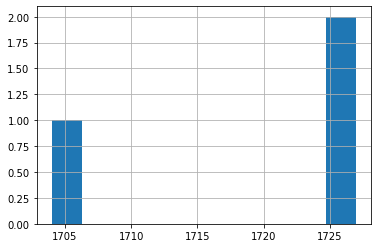

In [25]:
odf.hist()

In [26]:
odf.mean()

1719.3333333333333

It is **17:19**, hence my new suggested `prompt_time` is **5:20 pm**.

#### created_at:

In [27]:
df['created_time'] = df['created_at'].apply(lambda x: hour_miuntes(x))

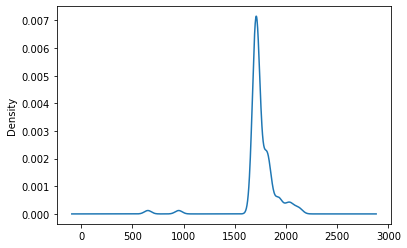

In [28]:
# snooze updates for the channel d7321b41-7815-47e1-936a-ad45b295d8b2
chdf = df[df['channel_id'] == "d7321b41-7815-47e1-936a-ad45b295d8b2"]
chdf['created_time'].plot.kde(bw_method=0.2)

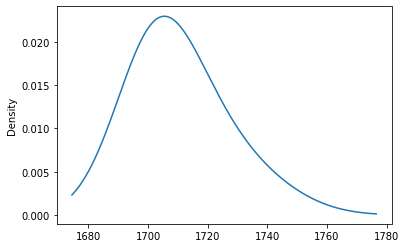

In [29]:
odf = chdf.query('created_time > 1500 & created_time < 1800')['created_time']
odf.plot.kde(bw_method=1)

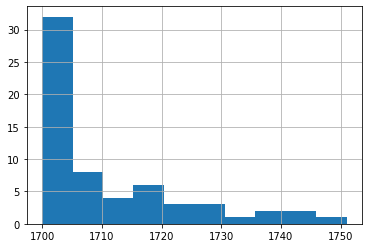

In [30]:
odf.hist()

In [31]:
odf.mean()

1710.516129032258

Which is **17:10**, hence `promt_time` at **5:20 pm** seems better choice than current `promt_time` **5 pm**.

#### **Suggestions for which data should be collected in the future to make a more robust prediction**:

- **In my opinion, it is better to have a self-adjusting mechanism for `prompt_time` which will adapt to the usage pattern of every user.**

e.g: 
**Initial value**: Delay = 0, prompt_time = 17:00, updated_at = None, cap = 30
* Day 1: 
  * prompt at -> 17:00
  * user updates after 15 minutes
  * calculate $delay_{new} = 11$
* Day 2: 
  * prompt at -> 17:11
  * user updates after 30 minutes
  * calculate $delay_{new} = 24$
* Day 3: 
  * prompt at -> 17:24
  * user updates after 30 minutes
  * calculate $delay_{new} = 28$
* Day 4: 
  * prompt at -> 17:28
  * user updates after 30 minutes
  * calculate $delay_{new} = 29$
* Day 5: 
  * prompt at -> 17:29
  * user updates after 30 minutes
  * calculate $delay_{new} = 30$
* Day 6: 
  * prompt at -> 17:30
  * user updates after 30 minutes
  * calculate $delay_{new} = 30$

- Proposed method:

  * $delay_{new}$ := `updated_at` - `prompt_time`

  * $
delay_{predicted}$ := $min(cap_{value}, \sqrt(\frac{(delay_{old} - delay_{new})^2}{2}))
$

  * $delay_{old}$ := `prompt_time` +/- $delay_{predicted}$